In [1]:
import os
import math
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy.signal as sig
from tifffile import imread
import matplotlib.pyplot as plt


In [2]:
class Furrow:
    def __init__(self, file_name):

        def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
            px = ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
            py = ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
            return [px, py]

        file_name_extensionless = file_name.rsplit('.', maxsplit=1)[0]
        components = file_name_extensionless.split('_')
        components = [int(component) for component in components]
        self.file_name = file_name
        group_dict = {0:'cntrl',1:'expmnt'}
        self.group = group_dict[components[0]]
        self.frame = components[1]
        x1_furrow = components[2]
        y1_furrow = components[3]
        x2_furrow = components[4]
        y2_furrow = components[5]
        self.furrow_x = [x1_furrow, x2_furrow]
        self.furrow_y = [y1_furrow, y2_furrow]
        x1_perp = components[7]
        y1_perp = components[8]
        x2_perp = components[9]
        y2_perp = components[10]
        self.perp_x = [x1_perp, x2_perp]
        self.perp_y = [y1_perp, y2_perp]
        self.intersection = findIntersection(x1_furrow, 
                                             y1_furrow, 
                                             x2_furrow, 
                                             y2_furrow, 
                                             x1_perp,
                                             y1_perp,
                                             x2_perp,
                                             y2_perp
                                             )
        
        self.background = (components[11])

## 220318

In [6]:
data_dir = Path('/Volumes/DOM_THREE/103DCE_220811_Mgc-MO/20220811_134031_Mgc-MO_16x/_projection/0_furrow_images_111ish/')
images = [file for file in os.listdir(data_dir) if file.endswith('.tif') and not file.startswith('.')]
#images = ['0_22_1104_1812_1353_1530_120_1065_1443_1350_1941_690.tif'] # sample image
images.sort()
plot = True     

data = {'file name'     : [],
        'group'         : [],
        'fwhm'          : [],
        'fwam'          : [],
        'peak intensity': [],
        'background'    : [],
        'cell length'   : [],
        'pcnt symmetry' : []
        }

for image_name in images:
    print(image_name)
    furrow = Furrow(image_name)
    '''
    y_coordinates = [furrow.furrow_y, furrow.perp_y]
    y_coordinates = np.ravel(y_coordinates)
    if any(y_coordinates < 1024):
        print(f'getting rid of {image_name}')
        continue
    '''

    pixel_size = 6.4
    magnification = 16
    scale_factor = pixel_size/magnification

    perp_length = math.sqrt( (np.diff(furrow.perp_x))**2 + (np.diff(furrow.perp_y))**2 ) * scale_factor
    perp_midpoint_x, perp_midpoint_y = sum(furrow.perp_x)/2 , sum(furrow.perp_y)/2
    intersection_x, intersection_y = furrow.intersection

    dist_to_mp = math.sqrt((perp_midpoint_x - intersection_x)**2 + (perp_midpoint_y - intersection_y)**2) * scale_factor
    dist_from_end = perp_length / 2
    percent_of_length = (dist_to_mp / dist_from_end) * 100

    data['cell length'].append(perp_length)
    data['pcnt symmetry'].append(percent_of_length)
    data['file name'].append(furrow.file_name)
    data['group'].append(furrow.group)
    data['background'].append(furrow.background)

    furrow.nums = imread(data_dir / image_name)
    im_width = furrow.nums.shape[1]
    num_measurements = (im_width-25) // 25
    start_indices = np.arange(0, 25*num_measurements, 25)

    fwhm = []       # store all full width at half max measurements
    fwam = []       # store all full width at 85% max measurements
    peak_max = []   # store all max peak intensities

    for ind in start_indices:
        furrow_mean = np.mean(furrow.nums[:,ind:ind+50], axis=1)
        smoothed = sig.savgol_filter(furrow_mean, window_length=15, polyorder=2)

        smooth_peaks, _ = sig.find_peaks(smoothed, prominence=(np.max(smoothed)-np.min(smoothed))*0.25)         # 25% peak prominance
        proms, leftBases, rightBases = sig.peak_prominences(smoothed, smooth_peaks)
        widths_50,       _,         _,          _ = sig.peak_widths(smoothed, smooth_peaks, rel_height=0.50)    # fwhm
        widths_85, heights, leftIndex, rightIndex = sig.peak_widths(smoothed, smooth_peaks, rel_height=0.85)    # fwam
        main_peak_index = np.argmax(widths_50)                                                                  # find the widest peak
        widths_50 = widths_50[main_peak_index]
        widths_85 = widths_85[main_peak_index]
        left_background = leftBases[main_peak_index]
        right_background = rightBases[main_peak_index]
        peak_amplitude = proms[main_peak_index]
        fwhm_left = leftIndex[main_peak_index]
        fwhm_right = rightIndex[main_peak_index]
        fwhm_height = heights[main_peak_index]
        fwhm.append(widths_50)
        fwam.append(widths_85)
        peak_max.append(smoothed[smooth_peaks[main_peak_index]])

        if plot == True:
            save_dir = data_dir / ('plots') / (furrow.file_name.split('.')[0])
            save_dir.mkdir(exist_ok=True, parents=True)
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
            #ax1.vlines(x = left_background, ymin = smoothed[left_background], ymax = smoothed[left_background] + peak_amplitude)
            #ax1.vlines(x = right_background, ymin = smoothed[right_background], ymax = smoothed[right_background] + peak_amplitude)
            #ax1.hlines(fwhm_height, fwhm_left, fwhm_right)
            ax1.plot(furrow_mean)
            ax1.plot(smoothed)

            ax2.plot(furrow.furrow_x, furrow.furrow_y)
            ax2.plot(furrow.perp_x, furrow.perp_y)
            ax2.plot(perp_midpoint_x, perp_midpoint_y, marker='o')
            ax2.plot(intersection_x, intersection_y, marker='*')
            for ax in (ax1, ax2):
                ax.set_xticks([])
                ax.set_yticks([])
            plt.savefig(save_dir / (str(ind) + '.png'))
            plt.close()
    
    data['fwhm'].append(np.mean(fwhm))
    data['fwam'].append(np.mean(fwam))
    data['peak intensity'].append(np.mean(peak_max))

0_110_1258_244_1230_422_69_1126_324_1376_342_126.tif
0_111_1291_107_1416_224_69_1278_218_1490_22_125.tif
0_111_732_714_764_1000_69_616_862_1006_878_137.tif
0_112_1552_478_1788_466_69_1660_320_1724_696_122.tif
0_116_1720_266_1740_16_69_1522_116_1928_170_115.tif
1_111_194_1454_386_1240_69_116_1132_490_1522_118.tif
1_112_1370_1358_1616_1330_69_1500_1132_1514_1534_133.tif
1_112_230_1790_406_1680_69_212_1600_462_1874_140.tif
1_112_452_1662_534_1606_69_428_1554_602_1764_145.tif
1_112_843_1285_772_1472_69_576_1300_938_1520_145.tif
1_112_922_1392_1106_1384_69_998_1230_1016_1600_162.tif
1_113_523_1535_660_1454_69_528_1416_840_1752_141.tif


In [7]:
def swarmBox(df, param, axis=None):
    sns.boxplot(x="group", y=param, data=df, palette = "Set2", showfliers = False, ax=axis)
    b = sns.swarmplot(x="group", y=param, data=df, color=".25", ax=axis)
    b.set_ylabel(param, fontsize = 10)
    b.set_xlabel("")
    
def ttest(data_names: list, df, param):
    if len(data_names) != 2:
        print("you must provide exactly two groups to perform a t-test")
        return
    print("Calculating T-Test for groups ", data_names)
    df = df.loc[(df['group'].isin(data_names))]                # copy out just the part of the df with our groups
    my_groups = {}                                                  # empty dict
    for group in data_names:                                        # iterate through individual groups
        temp = df.loc[(df['group'] == group)]                  # individual group
        temp = temp[[param]].to_numpy()               # np array of signal shifts
        my_groups[group] = temp                                     # set the name equal to array in dictionary

    statistic, pvalue = scipy.stats.ttest_ind(my_groups[data_names[0]], my_groups[data_names[1]])
    print('p value for a T-Test is', round(pvalue[0], 7))
    if pvalue[0] > 0.05:
        print('no significant difference found between groups')

In [8]:
df = pd.DataFrame(data=data)
df['furrow enrichment'] = (df['peak intensity'] - df['background']) / df['background']
df

,file name,group,fwhm,fwam,peak intensity,background,cell length,pcnt symmetry,furrow enrichment
0,0_110_1258_244_1230_422_69_1126_324_1376_342_1...,cntrl,20.092402,39.794349,150.623882,126,100.258865,5.537286,0.195428
1,0_111_1291_107_1416_224_69_1278_218_1490_22_12...,cntrl,22.644857,38.114532,149.894375,125,115.488528,37.546649,0.199155
2,0_111_732_714_764_1000_69_616_862_1006_878_137...,cntrl,17.951612,30.531301,163.704700,137,156.131227,31.707317,0.194925
3,0_112_1552_478_1788_466_69_1660_320_1724_696_1...,cntrl,22.515322,38.428744,169.008161,122,152.563167,19.574544,0.385313
4,0_116_1720_266_1740_16_69_1522_116_1928_170_11...,cntrl,26.295347,39.581864,132.396034,115,163.830156,2.359134,0.151270
5,1_111_194_1454_386_1240_69_116_1132_490_1522_1...,expmnt,26.377061,42.511870,127.148005,118,216.139214,1.365902,0.077525
6,1_112_1370_1358_1616_1330_69_1500_1132_1514_15...,expmnt,19.204937,34.091351,170.716708,133,160.897483,4.661375,0.283584
7,1_112_230_1790_406_1680_69_212_1600_462_1874_1...,expmnt,18.795785,38.394119,163.190019,140,148.364955,6.449739,0.165643
8,1_112_452_1662_534_1606_69_428_1554_602_1764_1...,expmnt,33.174205,49.392750,177.174081,145,109.087855,24.343569,0.221890
9,1_112_843_1285_772_1472_69_576_1300_938_1520_1...,expmnt,19.103085,31.767814,174.238796,145,169.443324,17.300814,0.201647


Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.7057083
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.6207191
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.5357944
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.8747709
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.043146
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.1780322
no significant difference found between groups


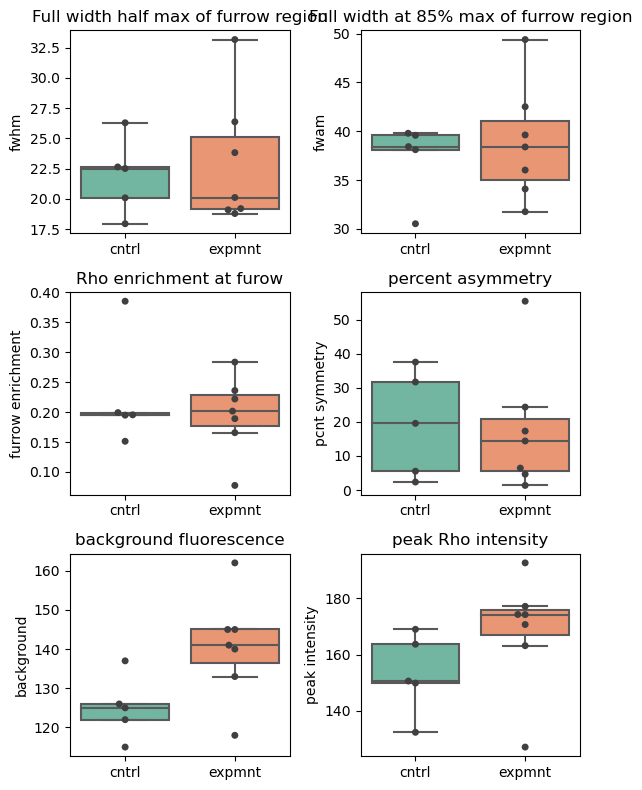

In [9]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(6,8), dpi=100)
swarmBox(df, param='fwhm', axis=ax1)
ax1.set_title('Full width half max of furrow region')
ttest(['cntrl', 'expmnt'], df=df, param='fwhm')
print('###'*10)
swarmBox(df, param='fwam', axis=ax2)
ax2.set_title('Full width at 85% max of furrow region')
ttest(['cntrl', 'expmnt'], df=df, param='fwam')
print('###'*10)
swarmBox(df, param='furrow enrichment', axis=ax3)
ax3.set_title('Rho enrichment at furow')
ttest(['cntrl', 'expmnt'], df=df, param='furrow enrichment')
print('###'*10)
swarmBox(df, param='pcnt symmetry', axis=ax4)
ax4.set_title('percent asymmetry')
ttest(['cntrl', 'expmnt'], df=df, param='pcnt symmetry')
fig.tight_layout()
print('###'*10)
swarmBox(df, param='background', axis=ax5)
ax5.set_title('background fluorescence')
ttest(['cntrl', 'expmnt'], df=df, param='background')
fig.tight_layout()
print('###'*10)
swarmBox(df, param='peak intensity', axis=ax6)
ax6.set_title('peak Rho intensity')
ttest(['cntrl', 'expmnt'], df=df, param='peak intensity')
fig.tight_layout()